<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week13/SOM_countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to SOM

In [3]:
# Re-import necessary libraries after code execution state reset
!pip install minisom --quiet

  Preparing metadata (setup.py) ... done


Data shape: (27, 2)


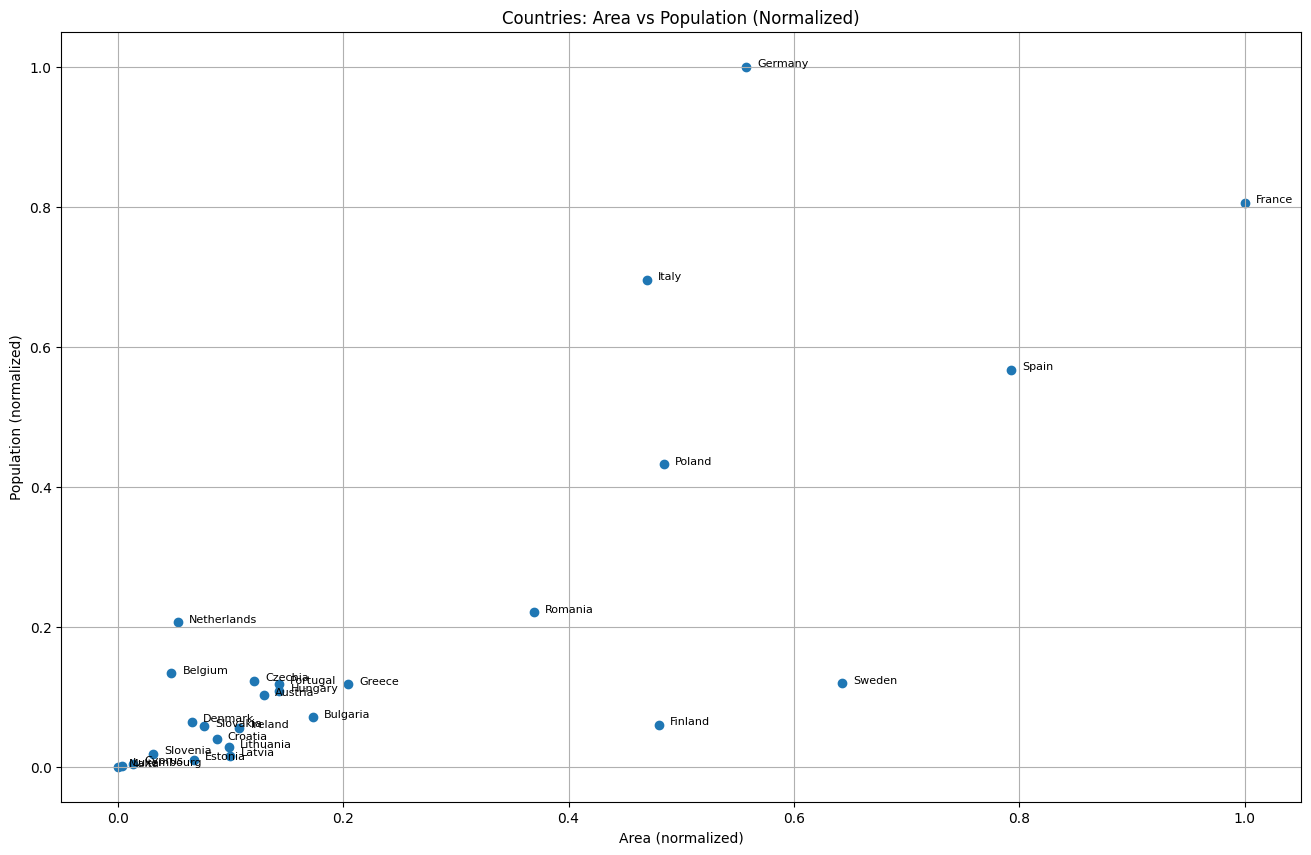

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Data: [Area, Population]
country_data = np.array([
    [82519, 9104772],
    [30452, 11754004],
    [110001, 6447710],
    [55896, 3850894],
    [9213, 920701],
    [77212, 10827529],
    [41987, 5932654],
    [43110, 1365884],
    [304316, 5563970],
    [633886, 68070697],
    [353296, 84358845],
    [130048, 10394055],
    [91248, 9597085],
    [68655, 5194336],
    [297825, 58850717],
    [63290, 1883008],
    [62643, 2857279],
    [2586, 660809],
    [313, 542051],
    [34188, 17811291],
    [307236, 36753736],
    [90996, 10467366],
    [234270, 19051562],
    [48702, 5428792],
    [20145, 2116792],
    [502654, 48059777],
    [407300, 10521556]
])

country_names = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
                 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
                 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
                 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']


print(f'Data shape: {country_data.shape}')

# Normalize the data (similar to mapminmax in MATLAB)
scaler = MinMaxScaler()
#scaler = StandardScaler()
data_scaled = scaler.fit_transform(country_data)

# --- Scatter plot of normalized data ---
plt.figure(figsize=(16,10))
plt.scatter(data_scaled[:,0], data_scaled[:,1])
for i, name in enumerate(country_names):
    plt.text(data_scaled[i,0]+0.01, data_scaled[i,1], name, fontsize=8)
plt.title("Countries: Area vs Population (Normalized)")
#plt.xscale('log')  # logarithmic scale (area)
#plt.yscale('log')  # logarithmic scale (population)
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True)
plt.show()




In [50]:
from minisom import MiniSom
from collections import defaultdict
# Initialize and train SOM
som_shape = (6, 6)
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=2, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_scaled)
som.train_random(data_scaled, 1000)

# Create a dictionary to store which countries fall into each SOM neuron (BMU)
bmu_positions = defaultdict(list)
for i, x in enumerate(data_scaled):
    bmu = som.winner(x)  # Best Matching Unit for each country
    bmu_positions[bmu].append(country_names[i])  # Group countries by BMU position



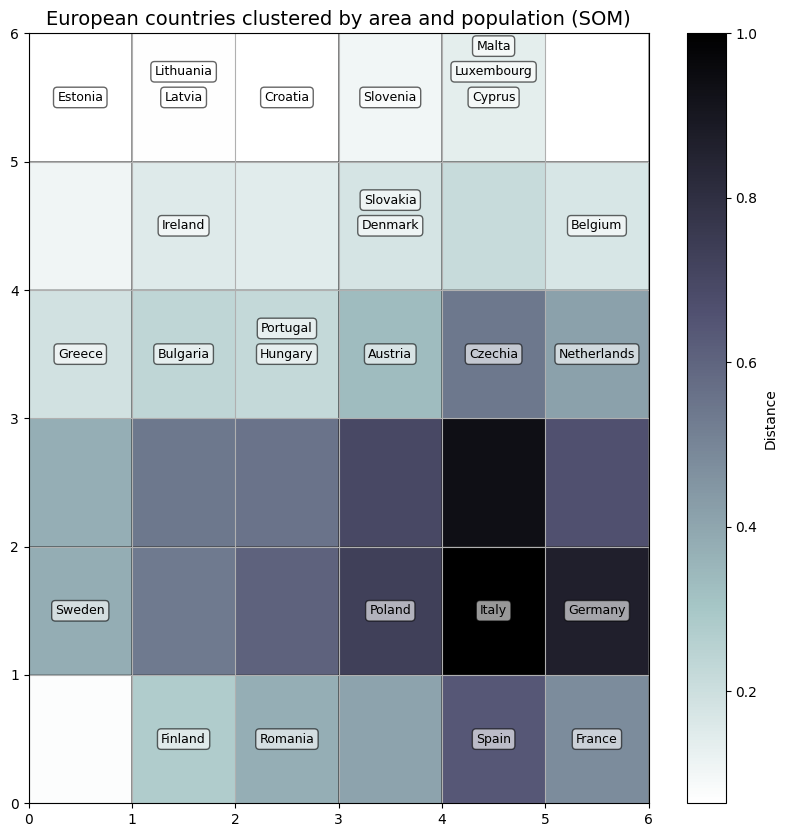

In [51]:
def plot_U_matrix(som, data_scaled, country_names):
    # Plot the U-matrix (Unified Distance Matrix
    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r', edgecolors='k')  # U-matrix as heatmap
    plt.colorbar(label='Distance')  # Color scale showing distance between neighboring neurons

    # Plot country names at their BMU positions, stacked vertically to avoid overlap
    for (x, y), names in bmu_positions.items():
        for i, name in enumerate(names):
            plt.text(x + 0.5, y + 0.5 + i * 0.2, name,  # vertical stacking
                    fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    # Add title and grid
    plt.title('European countries clustered by area and population (SOM)', fontsize=14)
    plt.grid(True)
    plt.show()
# Plot the U-matrix (Unified Distance Matrix)
plot_U_matrix(som, data_scaled, country_names)

In [52]:
# Get winner coordinates for each country
bmu_coords = np.array([som.winner(x) for x in data_scaled])

# Convert coordinates to 1D cluster IDs
cluster_ids = [int(x * som_shape[1] + y) for x, y in bmu_coords]

# Group countries by cluster
from collections import defaultdict
clusters = defaultdict(list)
for i, cid in enumerate(cluster_ids):
    clusters[cid].append(country_names[i])

# Print grouped countries
for cid, countries in sorted(clusters.items()):
    print(f"Representant {cid}: {countries}")


Representant 1: ['Sweden']
Representant 3: ['Greece']
Representant 5: ['Estonia']
Representant 6: ['Finland']
Representant 9: ['Bulgaria']
Representant 10: ['Ireland']
Representant 11: ['Latvia', 'Lithuania']
Representant 12: ['Romania']
Representant 15: ['Hungary', 'Portugal']
Representant 17: ['Croatia']
Representant 19: ['Poland']
Representant 21: ['Austria']
Representant 22: ['Denmark', 'Slovakia']
Representant 23: ['Slovenia']
Representant 24: ['Spain']
Representant 25: ['Italy']
Representant 27: ['Czechia']
Representant 29: ['Cyprus', 'Luxembourg', 'Malta']
Representant 30: ['France']
Representant 31: ['Germany']
Representant 33: ['Netherlands']
Representant 34: ['Belgium']


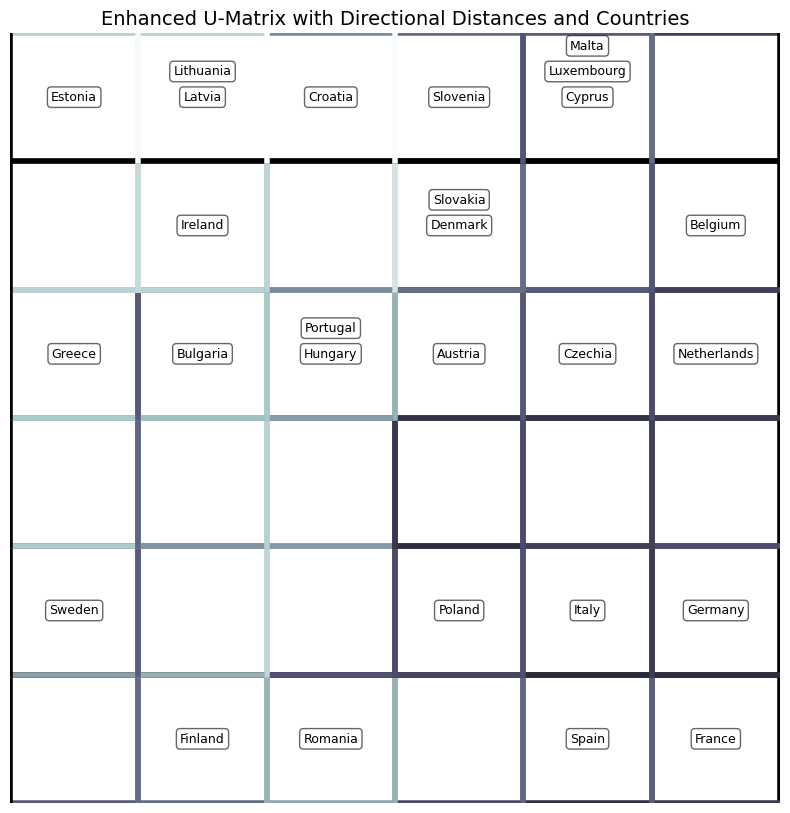

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from collections import defaultdict
from numpy.linalg import norm

# Compute directional distances for each neuron: [top, right, bottom, left]
weights = som.get_weights()
umatrix = np.zeros((som_shape[0], som_shape[1], 4))  # shape: (rows, cols, 4 directions)
max_dist = 0

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        if i > 0:  # top
            d = norm(w - weights[i - 1, j])
            umatrix[i, j, 0] = d
            max_dist = max(max_dist, d)
        if j < som_shape[1] - 1:  # right
            d = norm(w - weights[i, j + 1])
            umatrix[i, j, 1] = d
            max_dist = max(max_dist, d)
        if i < som_shape[0] - 1:  # bottom
            d = norm(w - weights[i + 1, j])
            umatrix[i, j, 2] = d
            max_dist = max(max_dist, d)
        if j > 0:  # left
            d = norm(w - weights[i, j - 1])
            umatrix[i, j, 3] = d
            max_dist = max(max_dist, d)

# Group countries by their BMU positions
bmu_positions = defaultdict(list)
for i, x in enumerate(data_scaled):
    bmu = som.winner(x)
    bmu_positions[bmu].append(country_names[i])

# Plot the enhanced U-matrix
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        x, y = j, i  # Grid coordinates

        # Normalize directional distances
        #top, right, bottom, left = umatrix[i, j] / max_dist
        top = np.sqrt(umatrix[i, j, 0] / max_dist)
        right = np.sqrt(umatrix[i, j, 1] / max_dist)
        bottom = np.sqrt(umatrix[i, j, 2] / max_dist)
        left = np.sqrt(umatrix[i, j, 3] / max_dist)

        # Base square
        ax.add_patch(Rectangle((x, y), 1, 1, facecolor='white', edgecolor='gray'))

        # Directional edge colors (top, right, bottom, left)
        ax.plot([x, x + 1], [y + 1, y + 1], color=cm.bone(top), linewidth=4)     # top
        ax.plot([x + 1, x + 1], [y, y + 1], color=cm.bone(right), linewidth=4)   # right
        ax.plot([x, x + 1], [y, y], color=cm.bone(bottom), linewidth=4)          # bottom
        ax.plot([x, x], [y, y + 1], color=cm.bone(left), linewidth=4)            # left

# Plot country names stacked vertically
for (x, y), names in bmu_positions.items():
    for i, name in enumerate(names):
        ax.text(x + 0.5, y + 0.5 + i * 0.2, name,
                fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

# Final layout settings
ax.set_xlim(0, som_shape[1])
ax.set_ylim(0, som_shape[0])
ax.set_ylim(som_shape[0], 0)
ax.set_aspect('equal')
plt.gca().invert_yaxis()  # Keep origin in top-left like in previous plots
plt.axis('off')
plt.title("Enhanced U-Matrix with Directional Distances and Countries", fontsize=14)
plt.show()


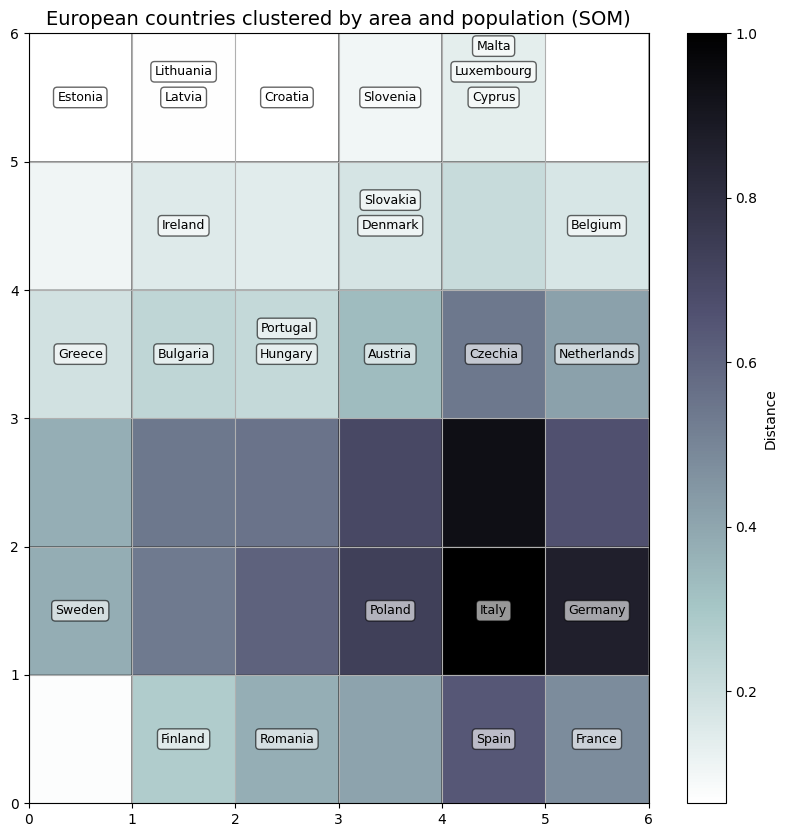

In [59]:
plot_U_matrix(som, data_scaled, country_names)

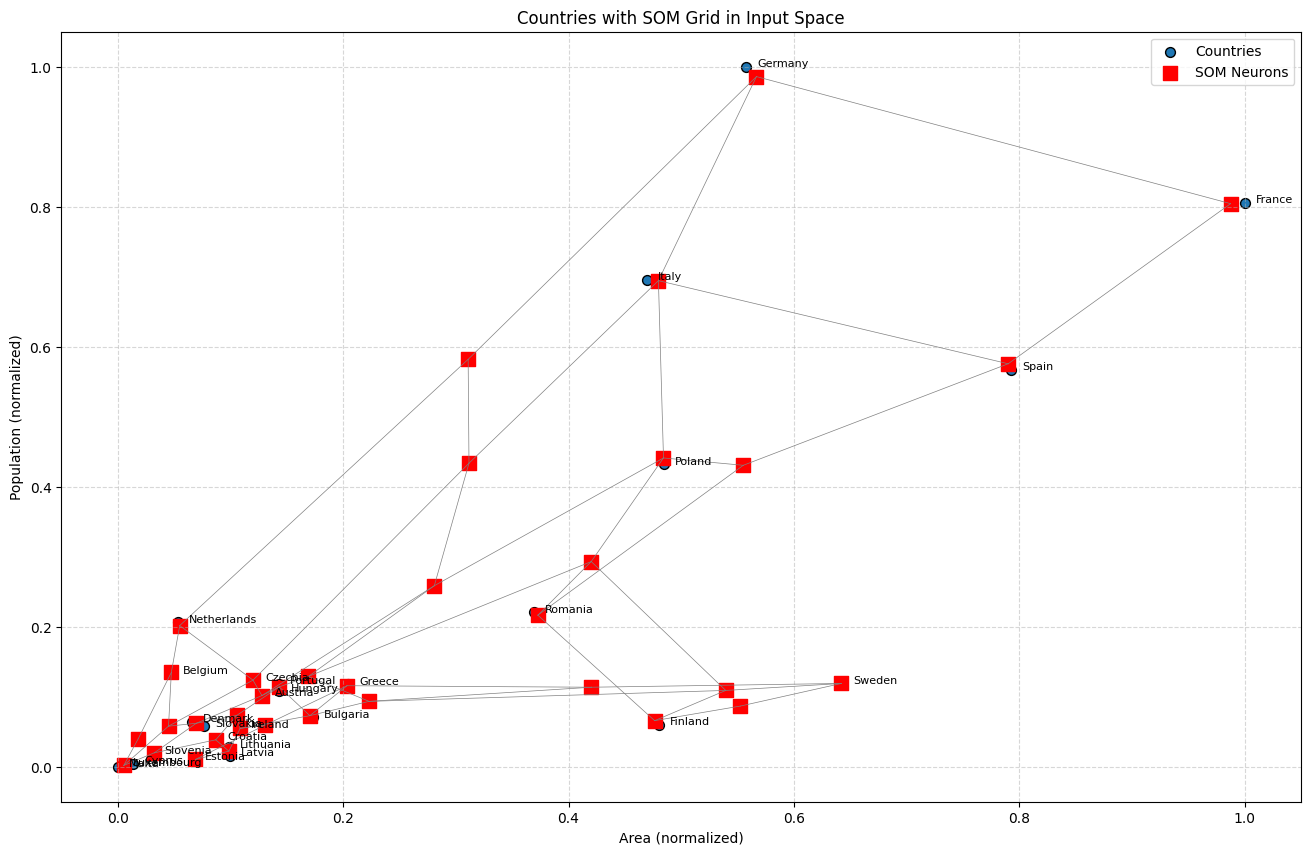

In [62]:
plt.figure(figsize=(16, 10))

# Plot data points
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], s=50, edgecolor='k', label='Countries')

# Add country names
for i, name in enumerate(country_names):
    plt.text(data_scaled[i, 0] + 0.01, data_scaled[i, 1], name, fontsize=8)

# Plot SOM neuron weights (i.e., grid in input space)
weights = som.get_weights().reshape(-1, data_scaled.shape[1])  # (num_neurons, 2)
plt.scatter(weights[:, 0], weights[:, 1], marker='s', s=100, c='red', label='SOM Neurons')

# Optionally: connect neurons in a grid (lines)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i, j + 1]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i + 1, j]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)

plt.title("Countries with SOM Grid in Input Space")
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


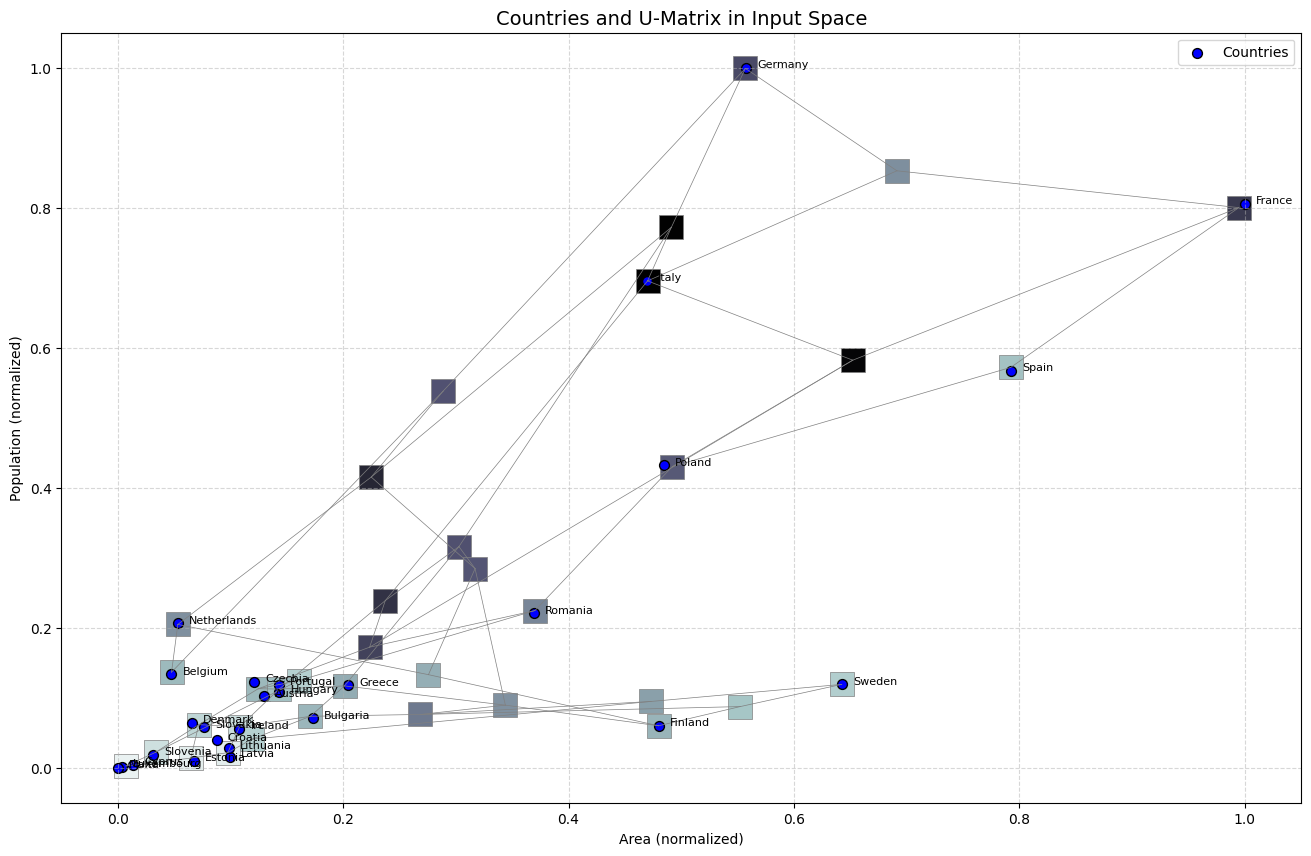

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Prepare U-matrix values as list of distances for each neuron
u_matrix = som.distance_map()

# Get weights and flatten them
weights = som.get_weights()
w_flat = weights.reshape(-1, weights.shape[2])  # shape (n_neurons, 2)

# Create figure
plt.figure(figsize=(16, 10))

# Plot U-matrix as background: place each neuron's U-value at its weight position
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        u = u_matrix[i, j]
        plt.scatter(w[0], w[1], color=cm.bone_r(u), s=300, marker='s', edgecolor='gray', linewidth=0.5)

# Connect neighboring neurons with gray lines (grid)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = weights[i, j]
        w2 = weights[i, j + 1]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = weights[i, j]
        w2 = weights[i + 1, j]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)

# Plot original data points (countries)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], s=50, edgecolor='black', facecolor='blue', label='Countries')
for i, name in enumerate(country_names):
    plt.text(data_scaled[i, 0] + 0.01, data_scaled[i, 1], name, fontsize=8)

# Final touches
plt.title("Countries and U-Matrix in Input Space", fontsize=14)
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


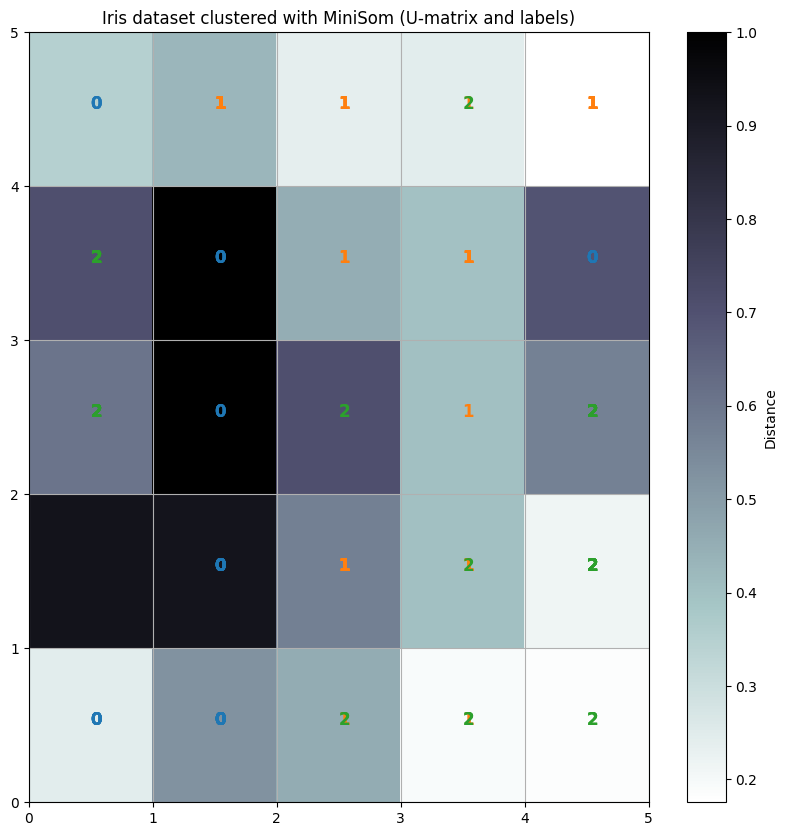

In [6]:

from minisom import MiniSom
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np

# Load Iris dataset
iris = load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names

# Initialize and train the SOM
som_shape = (5, 5)
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=data.shape[1], sigma=1.0, learning_rate=0.0001)
som.random_weights_init(data)
som.train_random(data, 1000)

# Create a mapping from class to color
colors = ['C0', 'C1', 'C2']
class_colors = [colors[t] for t in target]

# Plotting the SOM with data points colored by class
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # U-matrix
plt.colorbar(label='Distance')
for i, x in enumerate(data):
    w = som.winner(x)
    plt.text(w[0] + 0.5, w[1] + 0.5, str(target[i]),
             color=class_colors[i], fontdict={'weight': 'bold', 'size': 12})
plt.title('Iris dataset clustered with MiniSom (U-matrix and labels)')
plt.grid()
plt.show()


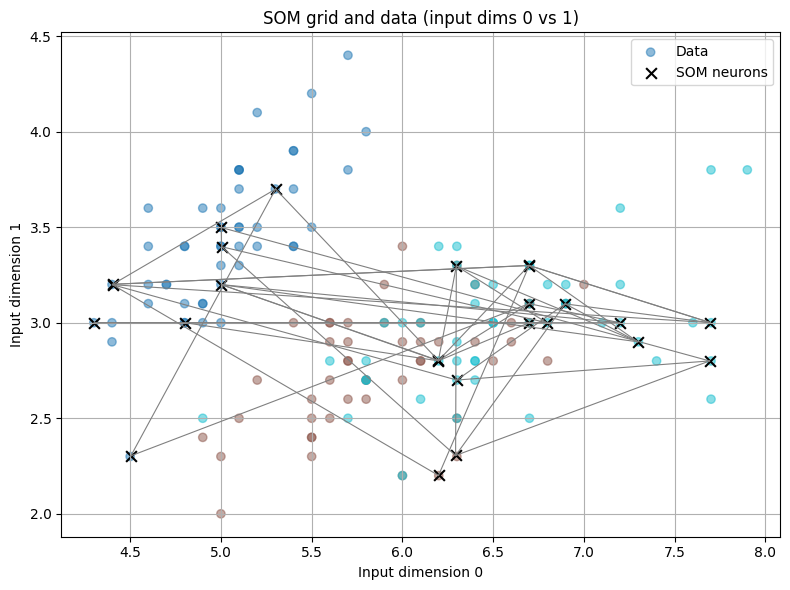

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Settings ---
dim_x, dim_y = 0, 1  # dimensions to plot from the input space
rows, cols = som._weights.shape[:2]

# --- SOM Weights ---
weights = som.get_weights().reshape(-1, data.shape[1])  # shape: [rows * cols, features]
projected_weights = weights[:, [dim_x, dim_y]]

# --- Original Data ---
projected_data = data[:, [dim_x, dim_y]]  # shape: [n_samples, 2]

# --- SOM Grid coordinates ---
grid_coords = np.array([(i, j) for i in range(rows) for j in range(cols)])

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot original data
plt.scatter(projected_data[:, 0], projected_data[:, 1],
            c=target, cmap='tab10', alpha=0.5, label='Data')

# Plot SOM neurons
plt.scatter(projected_weights[:, 0], projected_weights[:, 1],
            color='black', marker='x', s=60, label='SOM neurons')

# Connect SOM grid
for idx1, (i1, j1) in enumerate(grid_coords):
    for d in [(0, 1), (1, 0)]:  # connect to right and bottom neighbors
        i2, j2 = i1 + d[0], j1 + d[1]
        if i2 < rows and j2 < cols:
            idx2 = i2 * cols + j2
            plt.plot([projected_weights[idx1, 0], projected_weights[idx2, 0]],
                     [projected_weights[idx1, 1], projected_weights[idx2, 1]],
                     'gray', linewidth=0.8)

plt.title(f"SOM grid and data (input dims {dim_x} vs {dim_y})")
plt.xlabel(f"Input dimension {dim_x}")
plt.ylabel(f"Input dimension {dim_y}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


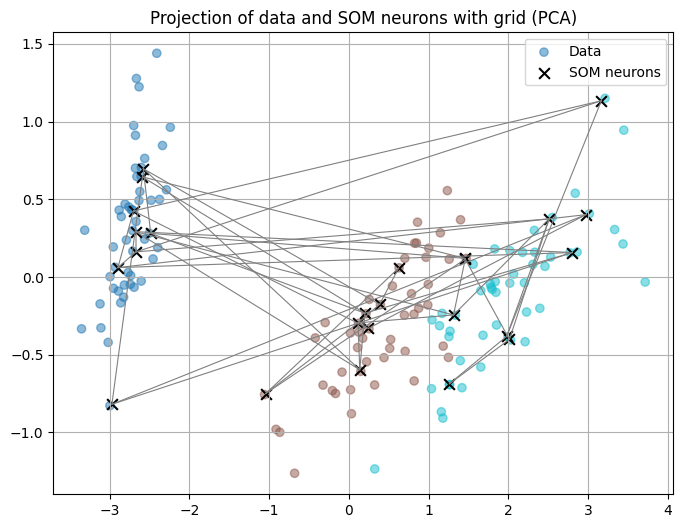

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reshape SOM weights and apply PCA
weights = som.get_weights().reshape(-1, data.shape[1])
pca = PCA(n_components=2)
projected_weights = pca.fit_transform(weights)
projected_data = pca.transform(data)

# Reconstruct grid coordinates (assuming rectangular SOM)
grid_size = som._weights.shape[:2]
rows, cols = grid_size
grid_coords = np.array([(i, j) for i in range(rows) for j in range(cols)])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1],
            c=target, cmap='tab10', alpha=0.5, label='Data')
plt.scatter(projected_weights[:, 0], projected_weights[:, 1],
            c='black', marker='x', s=60, label='SOM neurons')

# Connect neighboring neurons
for idx1, (i1, j1) in enumerate(grid_coords):
    for d in [(0, 1), (1, 0)]:  # right and down
        i2, j2 = i1 + d[0], j1 + d[1]
        if i2 < rows and j2 < cols:
            idx2 = i2 * cols + j2
            plt.plot([projected_weights[idx1, 0], projected_weights[idx2, 0]],
                     [projected_weights[idx1, 1], projected_weights[idx2, 1]],
                     'gray', linewidth=0.8)

plt.title("Projection of data and SOM neurons with grid (PCA)")
plt.legend()
plt.grid(True)
plt.show()


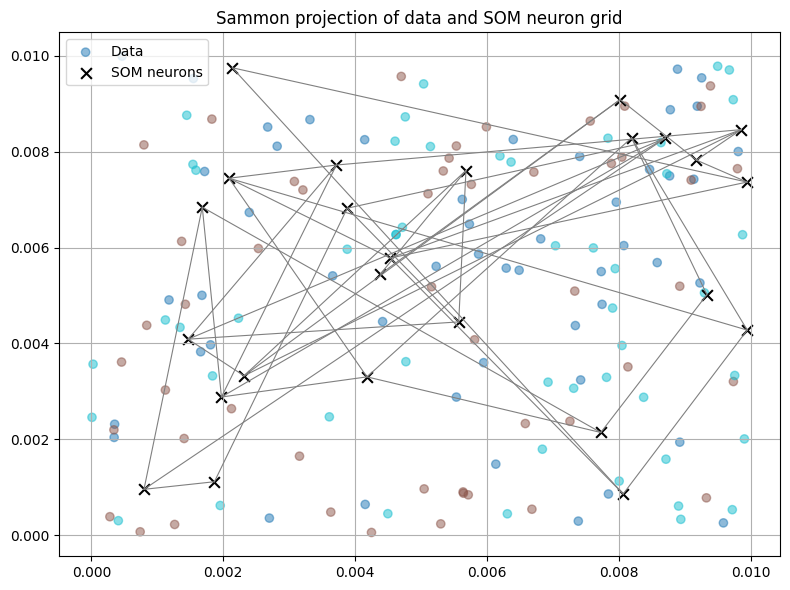

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

# --- Sammon mapping function ---
def sammon(X, n_components=2, max_iter=300, tol=1e-9):
    D = squareform(pdist(X))
    N = X.shape[0]

    D[D == 0] = 1e-12  # avoid division by zero
    scale = D.sum()

    Y = np.random.rand(N, n_components) * 0.01  # random initialization

    def loss(Y_flat):
        Y = Y_flat.reshape(N, n_components)
        d = squareform(pdist(Y))
        d[d == 0] = 1e-12
        ratio = (D - d) / D
        return ((ratio ** 2).sum()) / scale

    res = minimize(loss, Y.ravel(), method='L-BFGS-B', options={'maxiter': max_iter, 'ftol': tol})
    return res.x.reshape(N, n_components)

# --- Project SOM weights and data ---
weights = som.get_weights().reshape(-1, data.shape[1])
combined = np.vstack([data, weights])
embedding = sammon(combined)

# Separate projected data and neuron positions
projected_data = embedding[:len(data)]
projected_weights = embedding[len(data):]

# SOM grid layout
rows, cols = som._weights.shape[:2]
grid_coords = np.array([(i, j) for i in range(rows) for j in range(cols)])

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1],
            c=target, cmap='tab10', alpha=0.5, label='Data')
plt.scatter(projected_weights[:, 0], projected_weights[:, 1],
            c='black', marker='x', s=60, label='SOM neurons')

# Draw connections between neighboring SOM neurons
for idx1, (i1, j1) in enumerate(grid_coords):
    for d in [(0, 1), (1, 0)]:  # right and down neighbors
        i2, j2 = i1 + d[0], j1 + d[1]
        if i2 < rows and j2 < cols:
            idx2 = i2 * cols + j2
            plt.plot([projected_weights[idx1, 0], projected_weights[idx2, 0]],
                     [projected_weights[idx1, 1], projected_weights[idx2, 1]],
                     'gray', linewidth=0.8)

plt.title("Sammon projection of data and SOM neuron grid")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install scikit-learn-extra --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import SammonEmbedding

# Flatten SOM weights and stack them with data to fit joint embedding
weights = som.get_weights().reshape(-1, data.shape[1])
all_vectors = np.vstack([data, weights])

# Apply Sammon projection
sammon = SammonEmbedding(n_components=2, random_state=42)
projected_all = sammon.fit_transform(all_vectors)

# Split back the projections
projected_data = projected_all[:len(data)]
projected_weights = projected_all[len(data):]

# SOM grid structure
rows, cols = som._weights.shape[:2]
grid_coords = np.array([(i, j) for i in range(rows) for j in range(cols)])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1],
            c=target, cmap='tab10', alpha=0.5, label='Data')
plt.scatter(projected_weights[:, 0], projected_weights[:, 1],
            c='black', marker='x', s=60, label='SOM neurons')

# Draw connections between SOM neighbors
for idx1, (i1, j1) in enumerate(grid_coords):
    for d in [(0, 1), (1, 0)]:  # right and down
        i2, j2 = i1 + d[0], j1 + d[1]
        if i2 < rows and j2 < cols:
            idx2 = i2 * cols + j2
            plt.plot([projected_weights[idx1, 0], projected_weights[idx2, 0]],
                     [projected_weights[idx1, 1], projected_weights[idx2, 1]],
                     'gray', linewidth=0.8)

plt.title("Projection of data and SOM neurons with grid (Sammon Mapping)")
plt.legend()
plt.grid(True)
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

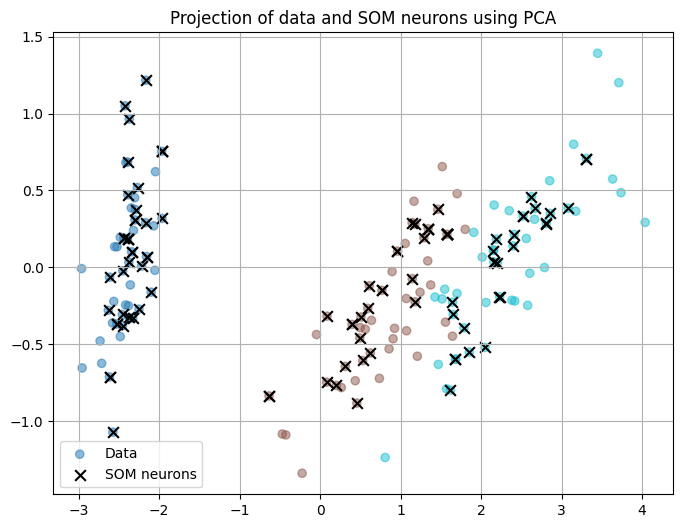

In [ ]:
# PCA projection of SOM weights and data
from sklearn.decomposition import PCA
weights = som.get_weights().reshape(-1, data.shape[1])
pca = PCA(n_components=2)
projected_weights = pca.fit_transform(weights)
projected_data = pca.transform(data)


# Plot
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=target, cmap='tab10', alpha=0.5, label='Data')
plt.scatter(projected_weights[:, 0], projected_weights[:, 1], c='black', marker='x', s=60, label='SOM neurons')
plt.legend()
plt.title("Projection of data and SOM neurons using PCA")
plt.grid(True)
plt.show()

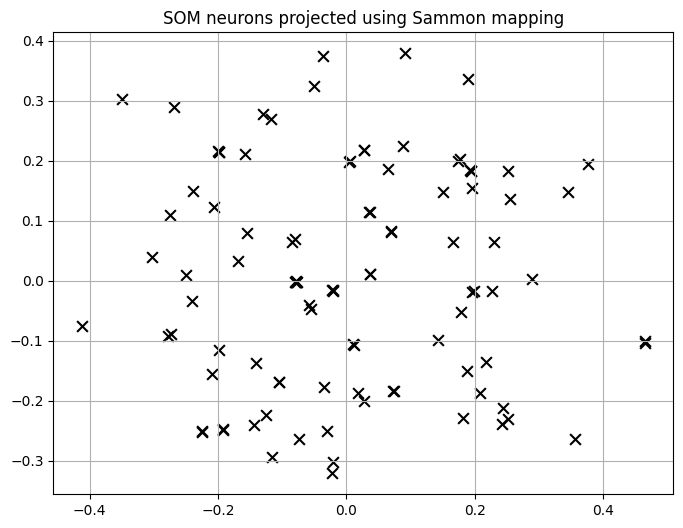

In [ ]:
import numpy as np
from minisom import MiniSom
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def sammon(X, n_components=2, max_iter=300, tol=1e-9):
    D = squareform(pdist(X))
    N = X.shape[0]

    D[D == 0] = 1e-12
    scale = D.sum()

    Y = np.random.rand(N, n_components) * 0.01

    def loss(Y_flat):
        Y = Y_flat.reshape(N, n_components)
        d = squareform(pdist(Y))
        d[d == 0] = 1e-12
        ratio = (D - d) / D
        return ((ratio ** 2).sum()) / scale

    res = minimize(loss, Y.ravel(), method='L-BFGS-B', options={'maxiter': max_iter, 'ftol': tol})
    return res.x.reshape(N, n_components)

# === 1. Train SOM on Iris ===
'''
iris = load_iris()
data = iris.data
som = MiniSom(10, 10, input_len=data.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data, 100)
'''
# === 2. Apply Sammon projection ===
weights = som.get_weights().reshape(-1, data.shape[1])
sammon_proj = sammon(weights, n_components=2)

# === 3. Visualize ===
plt.figure(figsize=(8,6))
plt.scatter(sammon_proj[:, 0], sammon_proj[:, 1], c='black', marker='x', s=60)
plt.title("SOM neurons projected using Sammon mapping")
plt.grid(True)
plt.show()


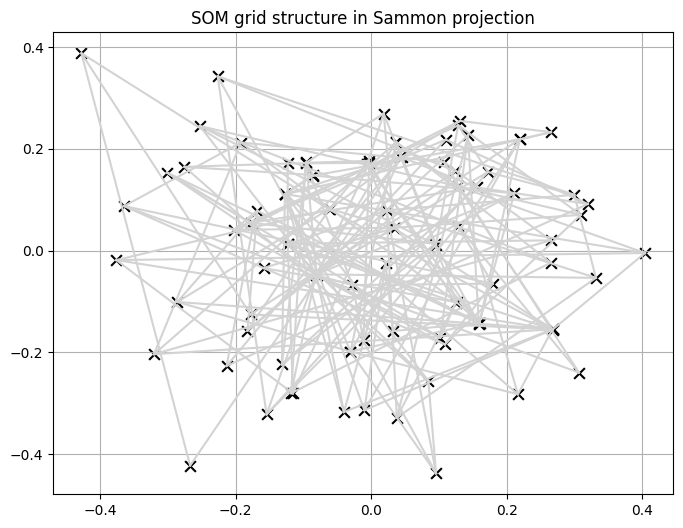

In [ ]:
# Rekonstrukce souřadnic v mřížce (př. 10x10)
grid_x, grid_y = np.meshgrid(np.arange(10), np.arange(10))
grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])

# Sammonova projekce vah
proj = sammon(weights, n_components=2)

#proj = PCA(n_components=2).fit_transform(weights)

plt.figure(figsize=(8, 6))
plt.scatter(proj[:, 0], proj[:, 1], c='black', marker='x', s=60)

# Propojit sousední neurony (topologie mřížky)
for i in range(len(grid_coords)):
    for j in range(i+1, len(grid_coords)):
        if np.linalg.norm(grid_coords[i] - grid_coords[j]) == 1:  # sousedé v mřížce
            plt.plot([proj[i, 0], proj[j, 0]], [proj[i, 1], proj[j, 1]], 'lightgray')

plt.title("SOM grid structure in Sammon projection")
plt.grid(True)
plt.show()

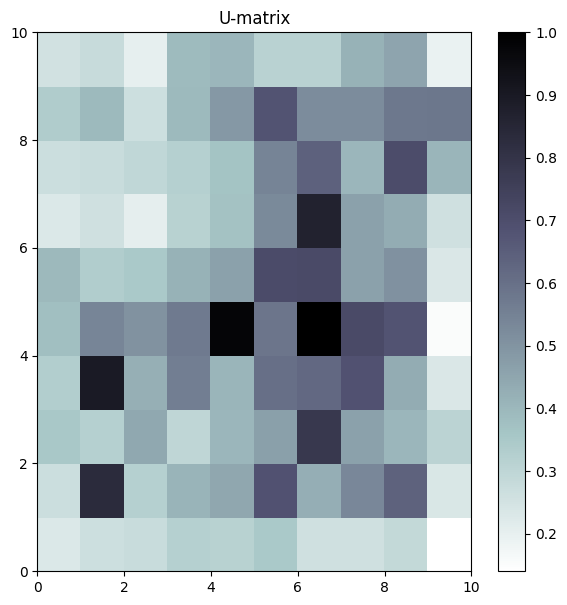

In [ ]:
# U-matrix plot
plt.figure(figsize=(7, 7))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title("U-matrix")
plt.show()